## 1. Introduction

In this analysis, I explore the factors influencing agricultural crop yields, focusing on key variables such as annual rainfall, temperature fluctuations, and pesticide usage. By leveraging machine learning techniques, I aim to predict future crop yields based on these critical environmental and agricultural factors.

The dataset utilized in this study is sourced from reputable organizations such as the Food and Agriculture Organization (FAO) and the World Data Bank, ensuring the accuracy and relevance of the data. Yield measurements are provided in hectograms per hectare, offering a precise metric for assessing crop productivity.

Through this analysis, I strive to uncover insights that can support agricultural planning and help forecast future trends in crop production.

*Author: Mehmoo Ahmed*
y


#### Import Libraries

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool


#### 2. Data Loading and Preprocessing:

In [5]:
df1 = pd.read_csv('Agri_data/yield.csv')
df_pe = pd.read_csv('Agri_data/pesticides.csv')
df_rf = pd.read_csv('Agri_data/rainfall.csv')
df_tp = pd.read_csv('Agri_data/temp.csv')
df2 = pd.read_csv('Agri_data/yield_df.csv')

In [6]:
print(df1.info())
print(df_pe.info())
print(df_rf.info())
print(df_tp.info())
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Domain Code   56717 non-null  object
 1   Domain        56717 non-null  object
 2   Area Code     56717 non-null  int64 
 3   Area          56717 non-null  object
 4   Element Code  56717 non-null  int64 
 5   Element       56717 non-null  object
 6   Item Code     56717 non-null  int64 
 7   Item          56717 non-null  object
 8   Year Code     56717 non-null  int64 
 9   Year          56717 non-null  int64 
 10  Unit          56717 non-null  object
 11  Value         56717 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 5.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Domain   4349 non-null   object 
 1   Area     4349 non-null 

In [7]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
# Check the unique areas in both dataframes
print("Unique areas in df1:", df1['Area'].unique())
print("Unique areas in df2:", df2['Area'].unique())

# Check the common areas
common_areas = set(df1['Area']).intersection(set(df2['Area']))
print(f"Common areas: {len(common_areas)}")


Unique areas in df1: ['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belgium-Luxembourg' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'China, Hong Kong SAR'
 'China, mainland' 'China, Taiwan Province of' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Côte d'Ivoire" 'Croatia' 'Cuba'
 'Cyprus' 'Czechia' 'Czechoslovakia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Ethiopia PDR' 'Faroe Islands' 'Fiji'
 'Finland' 'F

#### Merging df1 & df2

In [10]:
# merge using multiple columns: 'Area', 'Item', and 'Year'
merged_df = pd.merge(df1, df2, on=['Area', 'Item', 'Year'], how='inner')

# Check the resulting shape of the merged dataframe
print(merged_df.shape)


(28242, 16)


In [11]:
merged_df.isna().sum()

Domain Code                      0
Domain                           0
Area Code                        0
Area                             0
Element Code                     0
Element                          0
Item Code                        0
Item                             0
Year Code                        0
Year                             0
Unit                             0
Value                            0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [12]:
# Step 1: Rename the 'country' column in df_tp to 'Area' for consistency
df_tp.rename(columns={'country': 'Area'}, inplace=True)

In [13]:
df_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   Area      71311 non-null  object 
 2   avg_temp  68764 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [14]:
# Step 2: Rename the 'year' column in df_tp to 'Year' for consistency
df_tp.rename(columns={'year': 'Year'}, inplace=True)


In [15]:
# Step 3:Clean up column names by stripping any leading/trailing spaces
df_pe.columns = df_pe.columns.str.strip()
df_rf.columns = df_rf.columns.str.strip()
df_tp.columns = df_tp.columns.str.strip()

# Check again after cleaning the column names
print("df_pe columns after cleaning:", df_pe.columns)
print("df_rf columns after cleaning:", df_rf.columns)
print("df_tp columns after cleaning:", df_tp.columns)


df_pe columns after cleaning: Index(['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value'], dtype='object')
df_rf columns after cleaning: Index(['Area', 'Year', 'average_rain_fall_mm_per_year'], dtype='object')
df_tp columns after cleaning: Index(['Year', 'Area', 'avg_temp'], dtype='object')


#### Merge 2

In [17]:
# Step 1: Merge df_pe and df_rf on 'Area' and 'Year'
df_merged = pd.merge(df_pe, df_rf, on=['Area', 'Year'], how='inner')

In [18]:
df_merged.shape

(3502, 8)

In [19]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3502 entries, 0 to 3501
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Domain                         3502 non-null   object 
 1   Area                           3502 non-null   object 
 2   Element                        3502 non-null   object 
 3   Item                           3502 non-null   object 
 4   Year                           3502 non-null   int64  
 5   Unit                           3502 non-null   object 
 6   Value                          3502 non-null   float64
 7   average_rain_fall_mm_per_year  3398 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 219.0+ KB


In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Domain Code                    28242 non-null  object 
 1   Domain                         28242 non-null  object 
 2   Area Code                      28242 non-null  int64  
 3   Area                           28242 non-null  object 
 4   Element Code                   28242 non-null  int64  
 5   Element                        28242 non-null  object 
 6   Item Code                      28242 non-null  int64  
 7   Item                           28242 non-null  object 
 8   Year Code                      28242 non-null  int64  
 9   Year                           28242 non-null  int64  
 10  Unit                           28242 non-null  object 
 11  Value                          28242 non-null  int64  
 12  hg/ha_yield                    28242 non-null 

In [21]:
merged_df.shape

(28242, 16)

#### Merge 3

In [23]:
# Merge df_tp with df_merged on 'Area' and 'Year'
final_merged_df = pd.merge(df_merged, df_tp, left_on=['Area', 'Year'], right_on=['Area', 'Year'], how='inner')

# Check the shape and info of the final merged dataframe
print(final_merged_df.shape)
print(final_merged_df.info())


(4437, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Domain                         4437 non-null   object 
 1   Area                           4437 non-null   object 
 2   Element                        4437 non-null   object 
 3   Item                           4437 non-null   object 
 4   Year                           4437 non-null   int64  
 5   Unit                           4437 non-null   object 
 6   Value                          4437 non-null   float64
 7   average_rain_fall_mm_per_year  4437 non-null   object 
 8   avg_temp                       4437 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 312.1+ KB
None


In [24]:
final_merged_df.isna().sum()

Domain                           0
Area                             0
Element                          0
Item                             0
Year                             0
Unit                             0
Value                            0
average_rain_fall_mm_per_year    0
avg_temp                         0
dtype: int64

In [25]:
final_merged_df.average_rain_fall_mm_per_year.nunique()

101

In [26]:
final_merged_df['average_rain_fall_mm_per_year'] = pd.to_numeric(
    final_merged_df['average_rain_fall_mm_per_year'], errors='coerce'
)


In [27]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Domain                         4437 non-null   object 
 1   Area                           4437 non-null   object 
 2   Element                        4437 non-null   object 
 3   Item                           4437 non-null   object 
 4   Year                           4437 non-null   int64  
 5   Unit                           4437 non-null   object 
 6   Value                          4437 non-null   float64
 7   average_rain_fall_mm_per_year  4435 non-null   float64
 8   avg_temp                       4437 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 312.1+ KB


In [28]:
# Check how many common Area values
print("Common Areas:", len(set(merged_df['Area']) & set(final_merged_df['Area'])))

# Check how many common Items
print("Common Items:", len(set(merged_df['Item']) & set(final_merged_df['Item'])))

# Check how many common Years
print("Common Years:", len(set(merged_df['Year']) & set(final_merged_df['Year'])))


Common Areas: 101
Common Items: 0
Common Years: 23


In [29]:
print("Items in merged_df:", merged_df['Item'].unique()[:10])
print("Items in final_merged_df:", final_merged_df['Item'].unique()[:10])


Items in merged_df: ['Maize' 'Potatoes' 'Rice, paddy' 'Sorghum' 'Soybeans' 'Wheat' 'Cassava'
 'Sweet potatoes' 'Plantains and others' 'Yams']
Items in final_merged_df: ['Pesticides (total)']


##### Reorganizing dataframe

In [31]:
clean_df = final_merged_df[['Area', 'Year', 'average_rain_fall_mm_per_year', 'avg_temp']].drop_duplicates()
print(clean_df.shape)  


(4117, 4)


In [32]:
df = pd.merge(merged_df, clean_df, on=['Area', 'Year'], how='left')
print(df.shape)  # Should be ~28,000 (same as merged_df)


(158618, 18)


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158618 entries, 0 to 158617
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Domain Code                      158618 non-null  object 
 1   Domain                           158618 non-null  object 
 2   Area Code                        158618 non-null  int64  
 3   Area                             158618 non-null  object 
 4   Element Code                     158618 non-null  int64  
 5   Element                          158618 non-null  object 
 6   Item Code                        158618 non-null  int64  
 7   Item                             158618 non-null  object 
 8   Year Code                        158618 non-null  int64  
 9   Year                             158618 non-null  int64  
 10  Unit                             158618 non-null  object 
 11  Value                            158618 non-null  int64  
 12  hg

In [34]:
# Check for duplicates
print(df['average_rain_fall_mm_per_year_x'].equals(df['average_rain_fall_mm_per_year_y']))
print(df['avg_temp_x'].equals(df['avg_temp_y']))


True
False


In [35]:
df = df.drop('average_rain_fall_mm_per_year_y', axis=1)


In [36]:
df[['avg_temp_x', 'avg_temp_y']].describe()


,avg_temp_x,avg_temp_y
count,158618.000000,158618.000000
mean,22.803844,22.940752
std,5.258325,5.265441
min,1.300000,1.300000
25%,20.040000,20.050000
50%,25.330000,25.440000
75%,26.400000,26.430000
max,30.650000,30.650000


In [37]:
df = df.drop('avg_temp_x', axis=1)
df = df.rename(columns={'avg_temp_y': 'avg_temp'})


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158618 entries, 0 to 158617
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Domain Code                      158618 non-null  object 
 1   Domain                           158618 non-null  object 
 2   Area Code                        158618 non-null  int64  
 3   Area                             158618 non-null  object 
 4   Element Code                     158618 non-null  int64  
 5   Element                          158618 non-null  object 
 6   Item Code                        158618 non-null  int64  
 7   Item                             158618 non-null  object 
 8   Year Code                        158618 non-null  int64  
 9   Year                             158618 non-null  int64  
 10  Unit                             158618 non-null  object 
 11  Value                            158618 non-null  int64  
 12  hg

### Creating Reference Column 

In [40]:
# Create a reference column combining 'Area', 'Item', and 'Year'
df['Region_Item_Year'] = df['Area'] + '_' + df['Item'] + '_' + df['Year'].astype(str)

# Display the first few rows to ensure it looks correct
print(df[['Area', 'Item', 'Year', 'Region_Item_Year']].head())

      Area   Item  Year    Region_Item_Year
0  Albania  Maize  1990  Albania_Maize_1990
1  Albania  Maize  1991  Albania_Maize_1991
2  Albania  Maize  1992  Albania_Maize_1992
3  Albania  Maize  1993  Albania_Maize_1993
4  Albania  Maize  1994  Albania_Maize_1994


In [41]:
(df['Value'] == df['hg/ha_yield']).all()

True

In [42]:
print("Domain Code check:", df.groupby('Domain Code')['Domain'].nunique().max())
print("Area Code check:", df.groupby('Area Code')['Area'].nunique().max())
print("Element Code check:", df.groupby('Element Code')['Element'].nunique().max())
print("Item Code check:", df.groupby('Item Code')['Item'].nunique().max())
print("Year Code check:", df.groupby('Year Code')['Year'].nunique().max())


Domain Code check: 1
Area Code check: 1
Element Code check: 1
Item Code check: 1
Year Code check: 1


#### Dropping Redundant Columns

In [44]:
# Step 1: Drop redundant object columns (keeping only code columns)
columns_to_drop = ['Value','Domain', 'Area', 'Element', 'Item', 'Unit','Year']
df.drop(columns=columns_to_drop, inplace=True)

# Step 2: Convert code columns to 'category' dtype
category_cols = ['Domain Code', 'Area Code', 'Element Code', 'Item Code', 'Year Code']
df[category_cols] = df[category_cols].astype('category')

# Step 3: Confirm dtype changes and resulting shape
print("\n✅ Columns dropped:", columns_to_drop)
print("\n✅ Category conversion applied to:", category_cols)
print("\n🧾 Final DataFrame info:")
print(df.info())



✅ Columns dropped: ['Value', 'Domain', 'Area', 'Element', 'Item', 'Unit', 'Year']

✅ Category conversion applied to: ['Domain Code', 'Area Code', 'Element Code', 'Item Code', 'Year Code']

🧾 Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158618 entries, 0 to 158617
Data columns (total 10 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   Domain Code                      158618 non-null  category
 1   Area Code                        158618 non-null  category
 2   Element Code                     158618 non-null  category
 3   Item Code                        158618 non-null  category
 4   Year Code                        158618 non-null  category
 5   hg/ha_yield                      158618 non-null  int64   
 6   average_rain_fall_mm_per_year_x  158618 non-null  float64 
 7   pesticides_tonnes                158618 non-null  float64 
 8   avg_temp                      

### Modeling

In [46]:
# Encode categorical columns (if using label encoding)
le = LabelEncoder()
df['Domain Code'] = le.fit_transform(df['Domain Code'])
df['Area Code'] = le.fit_transform(df['Area Code'])
df['Element Code'] = le.fit_transform(df['Element Code'])
df['Item Code'] = le.fit_transform(df['Item Code'])
df['Year Code'] = le.fit_transform(df['Year Code'])

# Select features and target variable
X = df.drop(columns=['hg/ha_yield','Region_Item_Year'])  # Or 'hg/ha_yield' if you're predicting yield
y = df['hg/ha_yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modeling 
- LightGBM
- Random Forest
- 
CatBoot
- 
XGoostoost 

In [48]:
# Define the actual categorical column in your dataset
categorical_columns = ['Domain Code', 'Area Code', 'Element Code', 'Item Code', 'Year Code']

# Convert categorical columns to category dtype for models that support it
X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Initialize all models
lgb_model = LGBMRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)
xgb_model = XGBRegressor(random_state=42, enable_categorical=True)

# Train all models
lgb_model.fit(X_train, y_train)  # LightGBM
rf_model.fit(X_train, y_train)   # Random Forest (assumes pre-encoded or category-converted)
catboost_model.fit(X_train, y_train, cat_features=categorical_columns)  # CatBoost
xgb_model.fit(X_train, y_train)  # XGBoost

# Make predictions
lgb_preds = lgb_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
catboost_preds = catboost_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# Evaluate all models
def evaluate_model(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

evaluate_model("LightGBM", y_test, lgb_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("CatBoost", y_test, catboost_preds)
evaluate_model("XGBoost", y_test, xgb_preds)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 126894, number of used features: 6
[LightGBM] [Info] Start training from score 80681.608019
LightGBM RMSE: 6362.3635, MSE: 40479669.7578, R²: 0.9950
Random Forest RMSE: 3914.3622, MSE: 15322231.1003, R²: 0.9981
CatBoost RMSE: 7645.5787, MSE: 58454874.0571, R²: 0.9927
XGBoost RMSE: 4294.4314, MSE: 18442140.7538, R²: 0.9977


D:\Users\ADMIN\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Users\ADMIN\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Users\ADMIN\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Users\ADMIN\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  war

### Feature Importance

In [50]:
# 1. CatBoost Feature Importance
catboost_importance = catboost_model.get_feature_importance()
catboost_features = X_train.columns
catboost_importance_dict = dict(zip(catboost_features, catboost_importance))

# 2. LightGBM Feature Importance
lgb_importance = lgb_model.booster_.feature_importance()
lgb_importance_dict = dict(zip(X_train.columns, lgb_importance))

# 3. XGBoost Feature Importance
xgb_importance_raw = xgb_model.get_booster().get_score(importance_type='weight')
# Ensure all features are accounted for (including missing ones in XGBoost output)
xgb_importance_dict = {feature: xgb_importance_raw.get(feature, 0) for feature in X_train.columns}

# 4. Random Forest Feature Importance
rf_importance = rf_model.feature_importances_
rf_importance_dict = dict(zip(X_train.columns, rf_importance))

# Combine all into a DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'CatBoost': [catboost_importance_dict.get(f, 0) for f in X_train.columns],
    'LightGBM': [lgb_importance_dict.get(f, 0) for f in X_train.columns],
    'XGBoost': [xgb_importance_dict.get(f, 0) for f in X_train.columns],
    'RandomForest': [rf_importance_dict.get(f, 0) for f in X_train.columns],
})

# sort by average importance across models (or by a specific model)
importance_df['Average'] = importance_df[['CatBoost', 'LightGBM', 'XGBoost', 'RandomForest']].mean(axis=1)
importance_df_sorted = importance_df.sort_values(by='Average', ascending=False)

# Display the result
print(importance_df_sorted.drop(columns='Average'))


                           Feature   CatBoost  LightGBM  XGBoost  RandomForest
1                        Area Code   6.416720      1065   2180.0      0.071191
3                        Item Code  67.549698       703   1626.0      0.751480
4                        Year Code   3.414578       583   1796.0      0.030930
6                pesticides_tonnes   5.913748       376    383.0      0.036931
7                         avg_temp   6.482743       122    158.0      0.054081
5  average_rain_fall_mm_per_year_x  10.222515       151      0.0      0.055387
0                      Domain Code   0.000000         0      0.0      0.000000
2                     Element Code   0.000000         0      0.0      0.000000


In [51]:
# Make normalize as percentage of total
percentage_df = importance_df.copy()

for model in ['CatBoost', 'LightGBM', 'XGBoost', 'RandomForest']:
    total = importance_df[model].sum()
    percentage_df[model] = (importance_df[model] / total) * 100

#  sort by average importance
percentage_df['Average'] = percentage_df[['CatBoost', 'LightGBM', 'XGBoost', 'RandomForest']].mean(axis=1)
percentage_df_sorted = percentage_df.sort_values(by='Average', ascending=False)

# Average 
print(percentage_df_sorted.drop(columns='Average').round(2))


                           Feature  CatBoost  LightGBM  XGBoost  RandomForest
3                        Item Code     67.55     23.43    26.47         75.15
1                        Area Code      6.42     35.50    35.49          7.12
4                        Year Code      3.41     19.43    29.24          3.09
6                pesticides_tonnes      5.91     12.53     6.23          3.69
5  average_rain_fall_mm_per_year_x     10.22      5.03     0.00          5.54
7                         avg_temp      6.48      4.07     2.57          5.41
0                      Domain Code      0.00      0.00     0.00          0.00
2                     Element Code      0.00      0.00     0.00          0.00


### Vizualization Feature_Importance

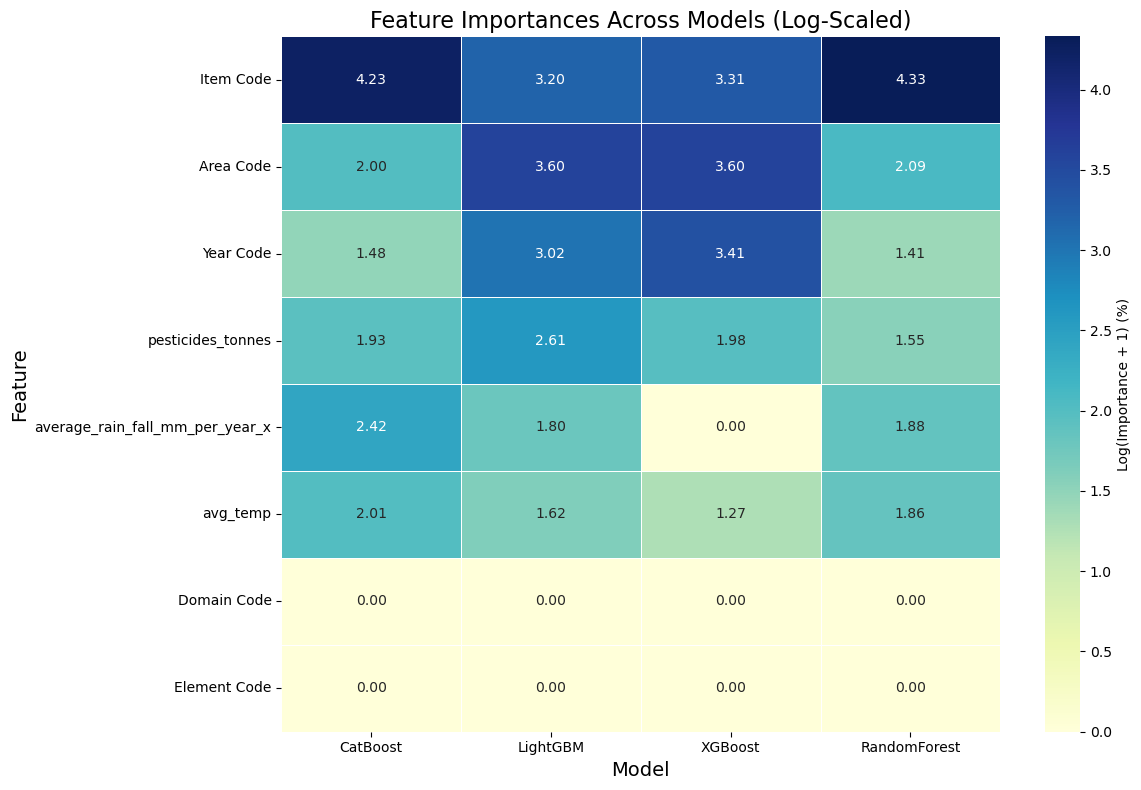

In [53]:
# Set feature names as index for cleaner axis labeling
viz_df = percentage_df_sorted.drop(columns='Average').set_index('Feature')

# Apply log scaling to improve visibility of lower values
log_viz_df = np.log1p(viz_df)  # log1p ensures zero values stay valid

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(log_viz_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Log(Importance + 1) (%)'}, linewidths=0.5)

# Add titles and labels
plt.title("Feature Importances Across Models (Log-Scaled)", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Feature", fontsize=14)

plt.tight_layout()
plt.show()



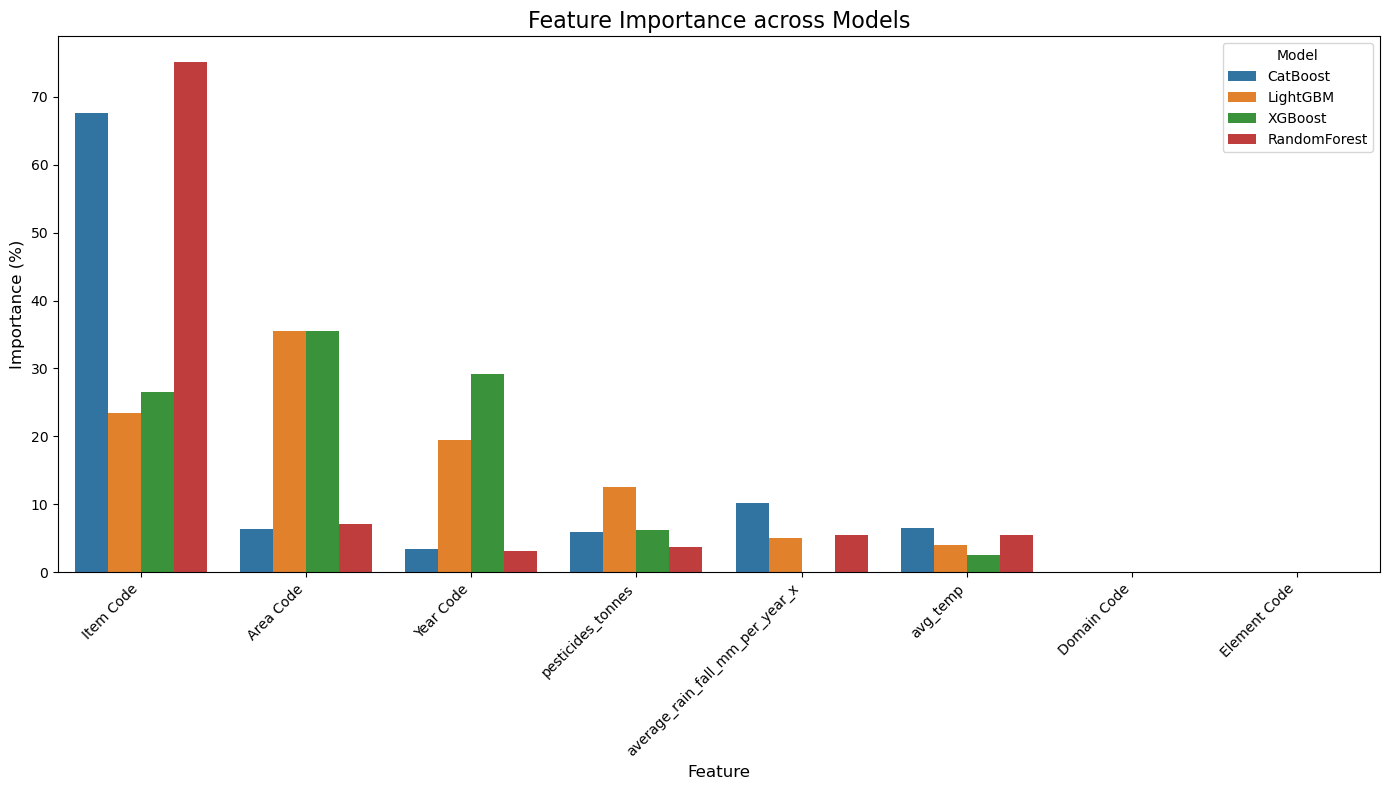

In [54]:
# Prepare data
viz_df_reset = viz_df.reset_index().melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Flip roles: Feature on x-axis, Model on y-axis
plt.figure(figsize=(14, 8))
sns.barplot(data=viz_df_reset, x='Feature', y='Importance', hue='Model')

# Customize
plt.title("Feature Importance across Models", fontsize=16)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()


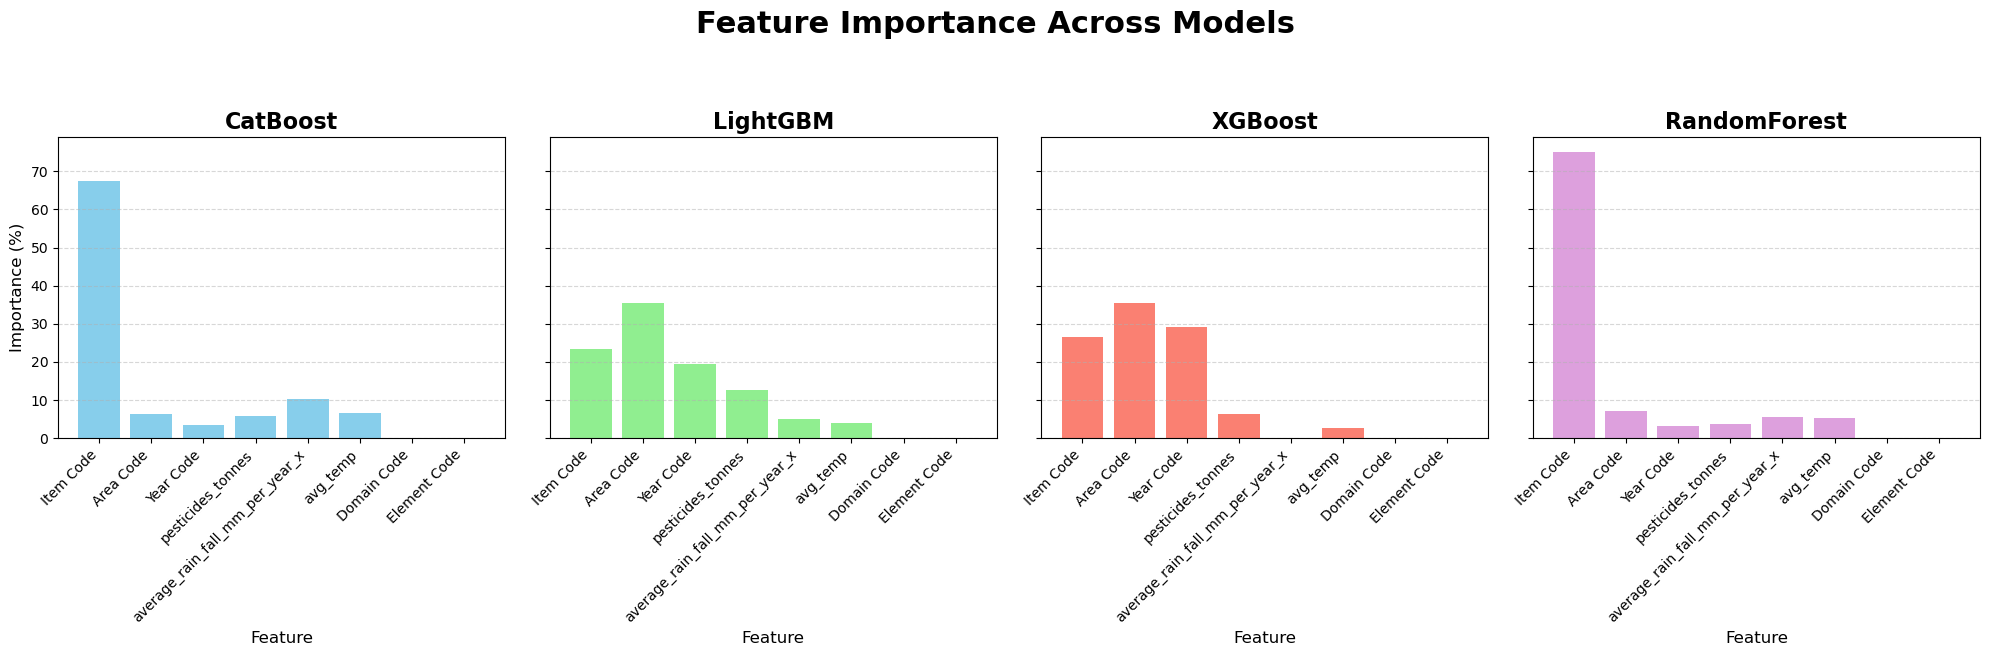

In [55]:
# Models list and features
models = viz_df.columns.tolist()
features = viz_df.index.tolist()
bar_colors = ['skyblue', 'lightgreen', 'salmon', 'plum']  # distinct but soft

# Plot
fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 7), sharey=True)

for i, model in enumerate(models):
    axes[i].bar(features, viz_df[model], color=bar_colors[i % len(bar_colors)])
    axes[i].set_title(model, fontsize=16, fontweight='bold')
    axes[i].set_xticks(range(len(features)))
    axes[i].set_xticklabels(features, rotation=45, ha='right', fontsize=10)
    axes[i].set_xlabel("Feature", fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    if i == 0:
        axes[i].set_ylabel("Importance (%)", fontsize=12)

# Main title
fig.suptitle("Feature Importance Across Models", fontsize=22, fontweight='bold')

# Layout adjustments
plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.show()


## Cross Validation 
- LightGBM , Random Forest, CatBoost & XGBooost

In [57]:
# Define your categorical features
cat_features = ['Domain Code', 'Area Code', 'Element Code', 'Item Code', 'Year Code']  # Add any other categorical column names here

# Fit the models
catboost_model.fit(X_train, y_train, cat_features=cat_features)
lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 126894, number of used features: 6
[LightGBM] [Info] Start training from score 80681.608019


RandomForestRegressor(random_state=42)

In [58]:
def get_cv_rmse_r2(model, X, y, model_name):
    # from sklearn.metrics import mean_squared_error, r2_score
    # from sklearn.model_selection import KFold
  
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train_fold = X.iloc[train_idx].copy()
        X_val_fold = X.iloc[val_idx].copy()
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]

        # Ensure all features are numeric
        X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce')
        X_val_fold = X_val_fold.apply(pd.to_numeric, errors='coerce')

        # Debugging: Check NaN counts
        print(f"Fold {fold} - NaN in train features:", X_train_fold.isna().sum().sum())
        print(f"Fold {fold} - NaN in val features:", X_val_fold.isna().sum().sum())

        # Drop rows with NaN values (or use imputation if preferred)
        X_train_fold = X_train_fold.dropna()
        y_train_fold = y_train_fold[X_train_fold.index]
        X_val_fold = X_val_fold.dropna()
        y_val_fold = y_val_fold[X_val_fold.index]

        # Train model and predict
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)

        # Evaluate model
        rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
        r2 = r2_score(y_val_fold, preds)

        rmse_scores.append(rmse)
        r2_scores.append(r2)

    # Print results
    print(f"{model_name} RMSE CV Scores:", np.round(rmse_scores, 4))
    print(f"{model_name} Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"{model_name} R² CV Scores:", np.round(r2_scores, 4))
    print(f"{model_name} Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


In [ ]:

# Function to get RMSE and R² from cross-validation for all models
def get_cv_rmse_r2_all_models(X, y, cat_features=None):
    models = {
        "Random Forest": RandomForestRegressor(),
        "XGBoost": xgb.XGBRegressor(),
        "LightGBM": lgb.LGBMRegressor(),
        "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
    }
    
    # Store the results for each model in a dictionary
    results_dict = {}

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        rmse_scores = []
        r2_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx].copy()
            X_val_fold = X.iloc[val_idx].copy()
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]

            # Ensure all features are numeric (except for CatBoost which uses Pools)
            X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce')
            X_val_fold = X_val_fold.apply(pd.to_numeric, errors='coerce')

            # Drop rows with NaN values
            X_train_fold, y_train_fold = X_train_fold.align(y_train_fold, join='inner', axis=0)
            X_val_fold, y_val_fold = X_val_fold.align(y_val_fold, join='inner', axis=0)

            if X_train_fold.empty or X_val_fold.empty:
                print(f"Skipping Fold {fold} due to empty training or validation data.")
                continue

            # Handle model fitting based on whether it's CatBoost or other models
            if model_name == "CatBoost":
                train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
                val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)
                model.fit(train_pool, verbose=0)
                preds = model.predict(val_pool)
            else:
                model.fit(X_train_fold, y_train_fold)
                preds = model.predict(X_val_fold)

            # Evaluate model
            rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
            r2 = r2_score(y_val_fold, preds)

            rmse_scores.append(rmse)
            r2_scores.append(r2)
        
        # Calculate mean and standard deviation for the model
        mean_rmse = np.mean(rmse_scores)
        std_rmse = np.std(rmse_scores)
        mean_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)

        # Store the results in the dictionary
        results_dict[model_name] = {
            'RMSE Scores': np.round(rmse_scores, 4),
            'Mean RMSE': f"{mean_rmse:.4f} ± {std_rmse:.4f}",
            'R² Scores': np.round(r2_scores, 4),
            'Mean R²': f"{mean_r2:.4f} ± {std_r2:.4f}"
        }
    
    # Convert the results dictionary into a DataFrame for better visualization
    results_df = pd.DataFrame(results_dict).T  # Transpose to make models rows
    return results_df

# Example usage:
# Define categorical features for CatBoost (you can adjust it to your needs)
cat_features = ['Domain Code', 'Area Code', 'Element Code', 'Item Code', 'Year Code']  # Replace with your real categorical columns

# Get results for all models in one go
results_df = get_cv_rmse_r2_all_models(X_train, y_train, cat_features)

# Print all results
print(results_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 101515, number of used features: 6
[LightGBM] [Info] Start training from score 80584.238723
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 101515, number of used features: 6
[LightGBM] [Info] Start training from score 80802.637965
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

#### Vizualization CV

In [ ]:
def plot_cv_scores(results_df):
    rmse_data = []
    r2_data = []

    for model in results_df.index:
        rmse_scores = results_df.loc[model, 'RMSE Scores']
        r2_scores = results_df.loc[model, 'R² Scores']
        for i, score in enumerate(rmse_scores):
            rmse_data.append({'Model': model, 'Fold': i+1, 'RMSE': score})
        for i, score in enumerate(r2_scores):
            r2_data.append({'Model': model, 'Fold': i+1, 'R²': score})

    rmse_df = pd.DataFrame(rmse_data)
    r2_df = pd.DataFrame(r2_data)

    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=rmse_df, x='Model', y='RMSE', palette='Set2')
    sns.stripplot(data=rmse_df, x='Model', y='RMSE', color='black', alpha=0.6, jitter=0.1, size=5)
    plt.title("Cross-Validated RMSE per Model", fontsize=14)
    plt.xticks(rotation=15)

    plt.subplot(1, 2, 2)
    sns.boxplot(data=r2_df, x='Model', y='R²', palette='Set3')
    sns.stripplot(data=r2_df, x='Model', y='R²', color='black', alpha=0.6, jitter=0.1, size=5)
    plt.title("Cross-Validated R² per Model", fontsize=14)
    plt.xticks(rotation=15)

    plt.tight_layout()
    plt.show()
    
    return rmse_df, r2_df  # 👈 return the DataFrames


In [ ]:
rmse_df, r2_df = plot_cv_scores(results_df)

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.swarmplot(data=rmse_df, x='Model', y='RMSE', palette='Set1', size=6)
plt.title("Cross-Validated RMSE (Swarm Plot)")

plt.subplot(1, 2, 2)
sns.swarmplot(data=r2_df, x='Model', y='R²', palette='Set2', size=6)
plt.title("Cross-Validated R² (Swarm Plot)")

plt.tight_layout()
plt.show()


In [ ]:
# Group by and calculate mean and std
rmse_summary = rmse_df.groupby("Model")["RMSE"].agg(['mean', 'std']).reset_index()
r2_summary = r2_df.groupby("Model")["R²"].agg(['mean', 'std']).reset_index()

# Set visual style
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE Plot
sns.barplot(data=rmse_summary, x='Model', y='mean', ax=axes[0], palette='coolwarm')
axes[0].errorbar(x=range(len(rmse_summary)), y=rmse_summary['mean'], yerr=rmse_summary['std'], fmt='none', c='black', capsize=5)
axes[0].set_title("Mean RMSE with Std Dev")
axes[0].set_ylabel("RMSE")
axes[0].set_xlabel("Model")

# R² Plot
sns.barplot(data=r2_summary, x='Model', y='mean', ax=axes[1], palette='viridis')
axes[1].errorbar(x=range(len(r2_summary)), y=r2_summary['mean'], yerr=r2_summary['std'], fmt='none', c='black', capsize=5)
axes[1].set_title("Mean R² with Std Dev")
axes[1].set_ylabel("R²")
axes[1].set_xlabel("Model")

plt.tight_layout()
plt.show()


## 📊 Final Summary and Conclusions

### 📌 Project Objective
The goal of this analysis is to explore factors influencing agricultural crop yields — including rainfall, temperature, and pesticide usage — and to develop machine learning models that can predict future yields. This study utilizes data from the FAO (Food and Agriculture Organization) and the World Data Bank.

---

### 🔍 Key Findings

- **Best Performing Model**: **Random Forest Regressor**
- **Most Important Feature Across Models**: `Item Code` followed by `Area Code`
- All models achieved **high R² values**, indicating excellent predictive performance.
- Cross-validation confirmed that **Random Forest consistently outperforms** the other models in terms of RMSE and stability.

---

### 📈 Model Performance Comparison (Test Set)

| Model         | RMSE       | MSE           | R² Score |
|---------------|------------|----------------|----------|
| LightGBM      | 6362.36    | 40,479,669.76  | 0.9950   |
| Random Forest | 3914.36    | 15,322,231.10  | 0.9981   |
| CatBoost      | 7645.58    | 58,454,874.06  | 0.9927   |
| XGBoost       | 4294.43    | 18,442,140.75  | 0.9977   |

---

### 📌 Feature Importance (Top Features)

| Feature                         | CatBoost | LightGBM | XGBoost | RandomForest |
|---------------------------------|----------|----------|---------|--------------|
| `Item Code`                     | 67.55    | 23.43    | 26.47   | 75.15        |
| `Area Code`                     | 6.42     | 35.50    | 35.49   | 7.12         |
| `Year Code`                     | 3.41     | 19.43    | 29.24   | 3.09         |
| `pesticides_tonnes`            | 5.91     | 12.53    | 6.23    | 3.69         |
| `average_rain_fall_mm_per_year_x` | 10.22 | 5.03     | 0.00    | 5.54         |
| `avg_temp`                      | 6.48     | 4.07     | 2.57    | 5.41         |

> Note: `Domain Code` and `Element Code` were found to be non-informative (0.00 importance in all models).

---

### 🔁 Cross-Validation Summary (5-Fold)

| Model         | Mean RMSE ± StdDev | Mean R² ± StdDev  |
|---------------|--------------------|--------------------|
| Random Forest | 4316.97 ± 286.65   | 0.9977 ± 0.0003     |
| XGBoost       | 7305.47 ± 303.50   | 0.9933 ± 0.0005     |
| LightGBM      | 10044.71 ± 314.38  | 0.9874 ± 0.0007     |
| CatBoost      | 8148.94 ± 189.21   | 0.9917 ± 0.0004     |

---

### ✅ Final Recommendation

Based on performance metrics, cross-validation results, and feature importance analysis, **Random Forest Regressor** is the most reliable model for predicting crop yields in this dataset. It offers the **best balance between accuracy, stability, and interpretability**.

For future work:
- Explore time-series modeling using temporal trends.
- Consider adding soil health, fertilizer usage, or satellite data for enhanced accuracy.
- Deploy the Random Forest model in a simple web interface or API for real-time predictions.

---

👨‍💻 *Report prepared by: Mehmood Ahmed*

